# Test AUC Callback - plot ROC

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set

from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.callbacks.classification import AUCCallback
from uad.callbacks.barycentre import BarycentreSchedule
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC

print(tf.__version__)

# !nvidia-smi

2.2.0


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)

(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)


In [4]:
latent_dim = 16

# compute metric on evaluation set
auc_metric = AUCCallback(x_val, y_val)

vae = ConvolutionalVAE(latent_dim)

vae.compile(optimizer=tf.keras.optimizers.Adam())

In [5]:
vae.fit(x_train0, x_train0, epochs=7, batch_size=128, callbacks=[auc_metric])

Epoch 1/7
38/38 [==============================] - 13s 336ms/step - loss: 373.0776 - reconstruction_loss: 372.7477 - kl_loss: 0.3299
Epoch 2/7
38/38 [==============================] - 12s 318ms/step - loss: 289.0728 - reconstruction_loss: 287.6318 - kl_loss: 1.4411
Epoch 3/7
38/38 [==============================] - 12s 317ms/step - loss: 238.7415 - reconstruction_loss: 236.9713 - kl_loss: 1.7702
Epoch 4/7
38/38 [==============================] - 12s 327ms/step - loss: 229.0327 - reconstruction_loss: 227.3080 - kl_loss: 1.7247
Epoch 5/7
38/38 [==============================] - 12s 319ms/step - loss: 204.1445 - reconstruction_loss: 202.4497 - kl_loss: 1.6947
Epoch 6/7
38/38 [==============================] - 12s 322ms/step - loss: 153.2041 - reconstruction_loss: 150.7343 - kl_loss: 2.4698
Epoch 7/7
38/38 [==============================] - 12s 320ms/step - loss: 134.1307 - reconstruction_loss: 131.1657 - kl_loss: 2.9650


## ROC curve

In [8]:
fpr, tpr, thresh = compute_ROC(x_test, vae.predict(x_test), y_test0)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b380beba08>)

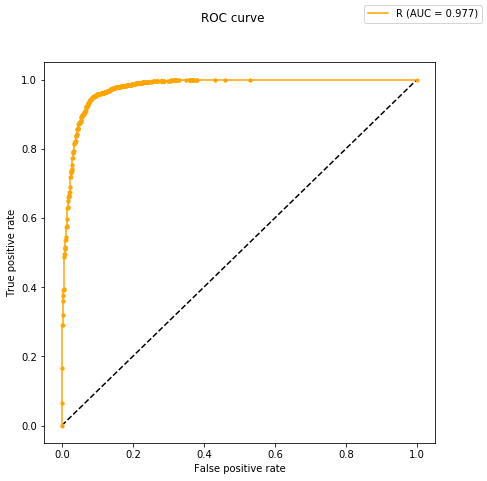

In [28]:
plot_ROC(fpr, tpr, labels="ROC Curve VAE")